## Do Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import pprint
from __future__ import division
from __future__ import print_function
from datetime import datetime
import matplotlib.pyplot as plt
import os
from fractions import Fraction 
import scipy.odr.odrpack as odrpack
import time
from bisect import bisect_left
import datetime as dt
import matplotlib.dates as mdates
import calendar
from sklearn import preprocessing

## Define functions for dataSet computation

In [2]:
def avageAndStdDeviationOverSeconds(dataPoints, currentIndex, collumToAnalyze, averagingSeconds):
    '''
    Returns a tupel, with outTupel[0] the average and outTupel[1] the standard deviation.
    Calculates the average and standard deviation over a given time.
    Starting from the data point at currentIndex in dataPoints and going back the number of averagingSeconds.
    It is assumed, that dataPonts is a Pandas DataFrame, with timestamps as indexes
    and that it is sortet, so that the latest/newest entry is at the beginning of the DataFrame.
    '''
    timestamps = dataPoints.axes[0]
    data = dataPoints.values
    outTupel = [0, 0]
    secondsAgo = timestamps[currentIndex] - averagingSeconds
    if ( timestamps[len(timestamps)-1] > secondsAgo):
        secondsAgo = timestamps[len(timestamps)-1]
    # cut array
    lastIndex = 0
    for i in range(currentIndex, len(data)):
        if timestamps[i] <= secondsAgo :
            lastIndex = i
            break
    cutData = np.split(dataPoints, [currentIndex, lastIndex + 1])[1]
    data = cutData.values
    columNames = cutData.axes[1]
    # calculate average and variance
    avg = cutData[columNames[collumToAnalyze]].mean()
    outTupel[0] = avg
    std = cutData[columNames[collumToAnalyze]].std()
    outTupel[1] = std
    return outTupel

def nextMeasurementAndDistance(dataPoints, currentIndex, collumToAnalyze, numberOfMeasurementsToSkip=0):
    '''
    Returns a tuple with outTupel[0] the next measurement in time and outTupel[1]
    the distance of the next measurement to the timestamp at currentIndex, devided by averagingSeconds
    TODO: evaluate, how usefull it is to devide by averagingSeconds [edit: just removed it because it seemed useless]
    '''
    countNum = numberOfMeasurementsToSkip
    timestamps = dataPoints.axes[0]
    data = dataPoints.values
    outTupel = [0, 0]
    nextIndex = currentIndex + 1
    while True:
        if nextIndex >= len(timestamps):
            nextIndex = currentIndex
            break
        if math.isnan(data[nextIndex][collumToAnalyze]) == False:
            if countNum == 0:
                break
            else:
                countNum -= 1
        nextIndex = nextIndex + 1
    outTupel[0] = data[nextIndex][collumToAnalyze]
    outTupel[1] = (timestamps[currentIndex] - timestamps[nextIndex])
    return outTupel


def findIndexClostestThatIsNotNAN(startIndex, dataPoints, collumThatIsNotNAN):
    '''
    Returns an index for dataPoints, that is:
    a) in the collum "collumThatIsNotNAN" not nan.
    b) closest to startIndex (looking fowards and backwards at the same time in the array).
       This "proximity" does not take the timestamp into account, just the numerical
       distance from startIndex to the returned index.
    If no occurence is found it will raise an error, but this case should be ultra rare.
    ATENTION: This function may look into the "future" of the data set which may not be possible in the future.
    '''
    hitBeginningOfList = False
    hitEndOfList = False
    index1 = startIndex
    index2 = startIndex
    while (hitEndOfList==False) or (hitBeginningOfList==False):
        index1 += 1
        index2 -= 1
        if (hitEndOfList == True) or (index1 == len(dataPoints)):
            hitEndOfList = True
        else:
            currentDataPoint = dataPoints.values[index1]
            if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
                return index1
        if (hitBeginningOfList == True) or (index2 == -1):
            hitBeginningOfList = True
        else:
            currentDataPoint = dataPoints.values[index2]
            if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
                return index2
    raise StandardError("Could not find a closest occurence, does the data even contain values in that colum?")


def findDataPointClosestToTimestamp(timestamp, dataPoints, collumThatIsNotNAN):
    '''
    Returns a data point from dataPoints, that is closest to the given timestamp.
    As well the dataPoint will not be nan in the collum "collumThatIsNotNAN"
    Complexity of this command: O( log( len(dataPoints) ) )
    '''
    timestamps_toSearch = dataPoints.axes[0]
    data = dataPoints.values
    # bisect only works because we know our list is sorted
    pos = bisect_left(timestamps_toSearch, timestamp)
    if pos == len(dataPoints):
        pos = len(dataPoints)-1
    # find the closest datapoint, that is not a NAN and return it
    currentDataPoint = dataPoints.values[pos]
    if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
        return currentDataPoint
    else:
        pos = findIndexClostestThatIsNotNAN(pos, dataPoints, collumThatIsNotNAN)
        currentDataPoint = dataPoints.values[pos]
        return currentDataPoint
    



def createDataSets(dataPoints_forth, dataPoints_back, averagingSeconds_Throughput, averagingSeconds_Delay_and_Loss):
    '''
    Returns a data sets (in form of a pandas DataFrame), derived from the given dataPoints_forth,
    and small parts of dataPoints_back.
    A data set contains information about throughput, packetloss and delay for a given point in time.
    '''
    timestamps = dataPoints_forth.axes[0]
    data = dataPoints_forth.values
    dataSetList = []
    # go through the data
    print("Current percentage of analyzed dataPoints: ")
    for i in range(len(dataPoints_forth)):
        # find a point, where we have throughput data
        if math.isnan(data[i][5]) == False:
            currentSet = {}
            # get all the throughput data:
            currentSet["timestamp"] = timestamps[i]
            currentSet["throughput_perfSonar"] = data[i][5]
            # take out this part at the moment as the network converges to fast
            '''avgAStdThroughput = avageAndStdDeviationOverSeconds(dataPoints_forth, i, 5, averagingSeconds_Throughput)
            currentSet["throughput_average"] = avgAStdThroughput[0]
            currentSet["throughput_std_deviation"] = avgAStdThroughput[1]
            nextAndDist = nextMeasurementAndDistance(dataPoints_forth, i, 5)
            currentSet["throughput_last_measurement"] = nextAndDist[0]
            currentSet["throughput_last_measurement_time"] = nextAndDist[1]'''
            
            # get closest throughput data from the routers
            nextValidIndex = findIndexClostestThatIsNotNAN(i, dataPoints_forth, 6)
            currentSet["throughput_router"] = data[nextValidIndex][6]
            
            # get all packetloss data:
            # TODO: replace this with a search in both directions
            nextValidIndex = findIndexClostestThatIsNotNAN(i, dataPoints_forth, 4)
            currentSet["packet_loss"] = data[nextValidIndex][4]
            avgAStdPacket_loss = avageAndStdDeviationOverSeconds(dataPoints_forth, nextValidIndex, 4, averagingSeconds_Delay_and_Loss)
            currentSet["packet_loss_average"] = avgAStdPacket_loss[0]
            currentSet["packet_loss_std_deviation"] = avgAStdPacket_loss[1]
            
            # get all delay data
            nextValidIndex = findIndexClostestThatIsNotNAN(i, dataPoints_forth, 2)
            fittingDataPoint_back = findDataPointClosestToTimestamp(currentSet["timestamp"], dataPoints_back, 2)
            currentSet["delay_current_average_forth"] = data[nextValidIndex][2]
            currentSet["delay_current_average_back"] = fittingDataPoint_back[2]
            currentSet["delay_current_std_deviation_forth"] = data[nextValidIndex][3]
            currentSet["delay_current_std_deviation_back"] = fittingDataPoint_back[3]
            avgAStdPacket_loss = avageAndStdDeviationOverSeconds(dataPoints_forth, nextValidIndex, 1, averagingSeconds_Delay_and_Loss)
            currentSet["delay_timed_average"] = avgAStdPacket_loss[0]
            currentSet["delay_timed_std_deviation"] = avgAStdPacket_loss[1]
            
            dataSetList.append(currentSet)
        if (i % 1000) == 0:
            print(str(100*i/len(dataPoints_forth)) +" %, " , end="")
    print(" ")
    print("Total created data sets: " + str(len(dataSetList)))
    dataFrame = pd.DataFrame.from_dict(dataSetList)
    return dataFrame


def createDatasetsFromFilesInFolder(path, averagingSeconds):
    '''
    This function is outdated at the moment and will crash!
    '''
    count = 0
    outputDataSets = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        # read all files
        for filename in filenames:
            print("----------------------- reading file: " + filename)
            dataPoints = pd.read_pickle(str(path + filename))
            # make sure it is sorted
            dataPoints.sort_index(inplace=True, ascending=False)
            dataSets = createDataSets(dataPoints, averagingSeconds)
            outputDataSets.append(dataSets)
            count =  count + 1
            print(" ")
    print("Number of read files: " + str(count))
    print(" ")
    return outputDataSets


In [3]:
def getDataSetWithPacketloss(dataSet):
    dataSetsWithPacketloss = dataSet.copy(deep=True)
    count = 0
    while count < len(dataSetsWithPacketloss):
        loss = dataSetsWithPacketloss['packet_loss'][count]
        # remove unwanted data:
        if loss < 0.0 and loss > 0.05:
            dataSetsWithPacketloss = dataSetsWithPacketloss.drop(count, axis=0)
            # no need to set the counter higher, since we removed a line
        else:
            # keep this line and conut one up
            count += 1
    print( "Number of dataSets with packet_loss: " + str(len(dataSetsWithPacketloss)))
    return dataSetsWithPacketloss

## Define functions for the analytical model

In [4]:
def calcMathisModel_outMBitsPerSec(packetloss, MSS, RTT, C=np.sqrt(3/2)):
    '''
    Returns the result of mathis model in Bits/s.
    It does work with np.arrays.
    '''
    outVal = (MSS/RTT)*C/np.sqrt(packetloss)
    # convert inf vals to nan
    outVal = outVal*np.isfinite(outVal)
    return outVal


In [5]:
# smir out data
def smoothDataFrame(data, steps):
    # make sure that there are no nans! This would brick the cumsum function!
    # This may happen naturally when the packet_loss is at 1, so no packets get through
    # for simplicity we will drop those lines    
    data_smired = data.copy(deep=True)
    if "packet_loss" in data_smired.axes[1]:
        data_smired = data_smired.dropna(axis=0, subset=["delay_avg"])
    for col in data_smired.axes[1]:
        # do NOT smir our "throughput_perfSonar"
        if col == "throughput_perfSonar":
            continue
        vals = data_smired[col].values
        valsSumed = np.cumsum(vals)
        for i in range(steps, len(data_smired)):
            summ = valsSumed[i] - valsSumed[i-steps]
            vals[i] = summ/steps
        vals[:steps] = float('nan')
        data_smired[col] = vals
    # make sure not to use the first values, which were not averaged, e.g. delete them
    data_smired = data_smired.drop(data_smired.index[:steps])
    return data_smired

## Import raw data and compute dataset

In [6]:
# read our raw data
data_router = pd.read_pickle("raw_data_routers/raw_router_CERN_to_RAL-PIC-TRIUMF-KIT-IN2P3-BNL-CNAF-JINR-T1_highres.pkl")
data_perfSonar = pd.read_pickle("raw_data_routers/raw_toolkit_CERN_to_RAL-PIC-TRIUMF-KIT-IN2P3-BNL-CNAF-JINR-T1_sorted.pkl")

In [7]:
# data processing
# smooth data
steps = 3
data_router = smoothDataFrame(data_router, steps)
steps = 15
for key1 in data_perfSonar.keys():
    for key2 in data_perfSonar[key1]:
        for key3 in data_perfSonar[key1][key2]:
            # smir the data
            data_perfSonar[key1][key2][key3] = smoothDataFrame(data_perfSonar[key1][key2][key3], steps)
            # add the gradient for delay_avg and packetloss
            data_perfSonar[key1][key2][key3]['delay_avg_gradient'] = np.gradient(data_perfSonar[key1][key2][key3]['delay_avg'], edge_order=2)
            data_perfSonar[key1][key2][key3]['packet_loss_gradient'] = np.gradient(data_perfSonar[key1][key2][key3]['packet_loss'], edge_order=2)
       
# make dates for the plots
dates_router = []
for stamp in data_router.index:
    dates_router.append(dt.datetime.fromtimestamp(stamp))
    
dates_perfSonar = {}
for src in data_perfSonar:
    dates_perfSonar[src] = {}
    for dest in data_perfSonar[src]:
        dates_perfSonar[src][dest] = {}
        for direction in data_perfSonar[src][dest]:
            dates_perfSonar[src][dest][direction] = []
            for stamp in data_perfSonar[src][dest][direction].index:
                dates_perfSonar[src][dest][direction].append(dt.datetime.fromtimestamp(stamp))
                

In [8]:
#test printing

counter = 0
for i in range(len(data_perfSonar['CERN']['RAL']['in']['throughput_perfSonar'])):
    if math.isnan(data_perfSonar['CERN']['RAL']['in']['throughput_perfSonar'].iloc[i]):
        continue
    counter += 1
print(counter)

for key1 in data_perfSonar.keys():
    print(key1 + " <-> ", end="")
    for key2 in data_perfSonar[key1].keys():
        print(key2 + " | ", end="")
    print(" ")

print(data_perfSonar['CERN']['KIT']['out'].axes[1])

99
CERN <-> CCIN2P3 | PIC | BNL | RAL | JINR-T1 | TRIUMF | KIT | CNAF |  
Index(['packet_loss', 'ttl_avg', 'ttl_std', 'ttl_median',
       'time_error_estimates', 'delay_avg', 'delay_std', 'delay_median',
       'throughput_perfSonar', 'delay_avg_gradient', 'packet_loss_gradient'],
      dtype='object')


## Scatter plotting

In [13]:
def makePlot_fromDataSet(src, dest, direction, timeframe, data_set, title_suffix='', savePath=''):
    # set stuff up
    direction_counter = "in"
    if direction == "in":
        direction_counter = "out"
    dirMarker = " <- "
    if direction == "out":
        dirMarker = " -> "
    title = "Multi plot for "+src+" "+dirMarker+" "+dest +"\nTimeframe: "+str(timeframe[0])+" to "+str(timeframe[1])+title_suffix
    fname = title
    # make dates
    dates_data_set = []
    for stamp in data_set['timestamp']:
        dates_data_set.append(dt.datetime.fromtimestamp(stamp))
    # plot the data we got
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18,12)
    fig.set_dpi(300)
    plt.title(title,fontsize=14)

    # make first axis
    ax1.plot(dates_data_set, data_set["delay_avg"]/10,
             'y', label=r'Delay /10')
    #ax1.plot(dates_perfSonar[src][dest][direction_counter], data_perfSonar[src][dest][direction_counter]["delay_avg"]/10,
    #         'c.', label=r'Reverse Direction: Delay /10')
    # get throughput
    ax1.plot(dates_data_set, data_set['throughput']/1e9,
             'b', label=r'Throughput all ('+str(len(throughputs))+') routers')
    
    # make second axis
    ax2 = ax1.twinx()
    ax2.plot(dates_data_set, data_set["packet_loss"],
             'g', label=r'Packetloss')

    # limits
    #ax1.set_ylim([0, 20])
    ax2.set_ylim([0, 0.05])
    plt.xlim([dt.datetime.strptime(t, '%d-%m-%Y %H:%M') for t in timeframe])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
    plt.gcf().autofmt_xdate()
    # legends and lables
    ax1.set_ylabel("Throughput [Gbit/s] and Latency [ms/10]")
    ax1.set_xlabel("Time [s since epoch]")
    ax1.legend(loc='upper left',fontsize=14)
    ax2.set_ylabel("Packetloss")
    ax2.legend(loc='upper right',fontsize=14)
    # saving?
    if savePath != '' :
        plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
    plt.show()

def findDataPointClosestToTimestamp_mod(timestamp, dataPoints, collumThatIsNotNAN):
    '''
    Returns a data point from dataPoints, that is closest to the given timestamp.
    As well the dataPoint will not be nan in the collum "collumThatIsNotNAN"
    Complexity of this command: O( log( len(dataPoints) ) )
    '''
    timestamps_toSearch = dataPoints.axes[0]
    cols = list(dataPoints.axes[1])
    data = dataPoints.values
    # bisect only works because we know our list is sorted
    pos = bisect_left(timestamps_toSearch, timestamp)
    if pos == len(dataPoints):
        pos = len(dataPoints)-1
    #print(pos)
    # find the closest datapoint, that is not a NAN and return it
    currentDataPoint = dict(zip(cols, dataPoints.values[pos]))
    if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
        return currentDataPoint
    else:
        pos = findIndexClostestThatIsNotNAN(pos, dataPoints, cols.index(collumThatIsNotNAN))
        currentDataPoint = dict(zip(cols, dataPoints.values[pos]))
        return currentDataPoint

def makeNewDataSet_scatterPlot(data_from_routers, data_from_perfSonar, timeframe):
    data_from_routers_gradient = np.gradient(data_from_routers, edge_order=2)
    # bisect doesn't work if the data is not sortet this way...
    data_from_routers = data_from_routers.sort_index(ascending=True).copy(deep=True)
    data_from_perfSonar = data_from_perfSonar.sort_index(ascending=True).copy(deep=True)
    # cut routers data
    pos1 = bisect_left(data_from_routers.index, timeframe[0])
    if pos1 == len(data_from_routers):
        pos1 = len(data_from_routers)-1
    pos2 = bisect_left(data_from_routers.index, timeframe[1])
    if pos2 == len(data_from_routers):
        pos2 = len(data_from_routers)-1
    data_from_routers = data_from_routers.drop(data_from_routers.index[0:pos1])
    data_from_routers = data_from_routers.drop(data_from_routers.index[pos2:len(data_from_routers)-1])
    data = []
    for i in range(len(data_from_routers)):
        currentTimestamp = data_from_routers.index[i]
        #print(currentTimestamp)
        zw = findDataPointClosestToTimestamp_mod(currentTimestamp, data_from_perfSonar, 'delay_avg')
        zw['timestamp'] = currentTimestamp
        zw['throughput'] = data_from_routers.values[i]
        zw['throughput_gradient'] = data_from_routers_gradient[i]
        data.append(zw)
    data = pd.DataFrame.from_dict(data)
    return data

def filter_low_throughput(throughputMaxGBits, throughputPercentage, data_set):
    data_set_out = data_set.copy(deep=True)
    counter = 0
    while counter < len(data_set_out):
        if data_set_out.iloc[counter]['throughput'] < (throughputMaxGBits*1e9*throughputPercentage):
            data_set_out = data_set_out.drop(data_set_out.index[counter])
        else:
            counter += 1
    return data_set_out

def filter_low_latency(data_set, std_adjustor=0.25):
    data_set_out = data_set.copy(deep=True)
    std = data_set_out['delay_avg'].std()*std_adjustor
    minimum = data_set_out['delay_avg'].min()
    print("Delay Filter: cutting at: "+str(minimum+std)+" = minimum:"+ str(minimum)+" + std:"+str(std))
    # drop all rows, which are in the range of half a standard deviation
    counter = 0
    while counter < len(data_set_out):
        if data_set_out.iloc[counter]['delay_avg'] < (minimum+std):
            data_set_out = data_set_out.drop(data_set_out.index[counter])
        else:
            counter += 1
    return data_set_out

def filter_low_packet_loss(data_set, min_packetloss=0.0001):
    data_set_out = data_set.copy(deep=True)
    # drop all rows, which are in the range of half a standard deviation
    counter = 0
    while counter < len(data_set_out):
        if data_set_out.iloc[counter]['packet_loss'] < (min_packetloss):
            data_set_out = data_set_out.drop(data_set_out.index[counter])
        else:
            counter += 1
    return data_set_out

In [14]:
# make Scatter plot
# configuration
src = "CERN"
dest = "TRIUMF"
direction = "in"
further_info='delay*packet_loss'
#further_info='latency*packet_loss'
#further_info = "latency * log( packet_loss*1e6+1 )"
throughputMaxGBits = 10
throughputPercentage = 0.7
timeframe_readable = ['14-09-2016 00:00', '18-09-2016 00:00']


# setting stuff up
timeframe = [calendar.timegm(dt.datetime.strptime(t, '%d-%m-%Y %H:%M').timetuple()) for t in timeframe_readable]
#timeframe = [1473811200, 1474756800]
dirMarker = " <- "
if direction == "out":
    dirMarker = " -> "
title = "Scatter plot "+src+dirMarker+dest +"\n"+further_info+"\nTimeframe: "+str(timeframe_readable[0])+" to "+str(timeframe_readable[1])
fname = title

# make dataSet
throughputs = []
for router in data_router.axes[1]:
    if dest in router and direction in router[len(router)-3:]:
        throughputs.append(data_router[router])
data_from_routers = sum(throughputs).copy(deep=True)
data_from_perfSonar = data_perfSonar[src][dest][direction].copy(deep=True)
data_set = makeNewDataSet_scatterPlot(data_from_routers, data_from_perfSonar, timeframe)
data_set_noFilter = data_set

# filter data_set

# filter data out which is inside the "normal" usage parameter
# std_adjustor should be fitting to the data, if there are only small variances (see TRIUMF),
# then a small value like ~0.4 might be good, for larger variances (see RAL),
# something like ~1 might be good.
data_set = filter_low_latency(data_set, std_adjustor=1)
data_set = filter_low_packet_loss(data_set, min_packetloss=0.0001)

# filter low bandwiths
#data_set = filter_low_throughput(throughputMaxGBits, throughputPercentage, data_set)

len(data_set)

Delay Filter: cutting at: 78.9458120011 = minimum:74.8891888889 + std:4.056623112202141


114

In [15]:
# make plot with filter
# configuration
savePath = ''
#savePath = 'plots/a_presentation_plots/'

#makePlot_fromDataSet(src, dest, direction, timeframe_readable, data_set, title_suffix="\ndelay&packet_loss filter", savePath=savePath)

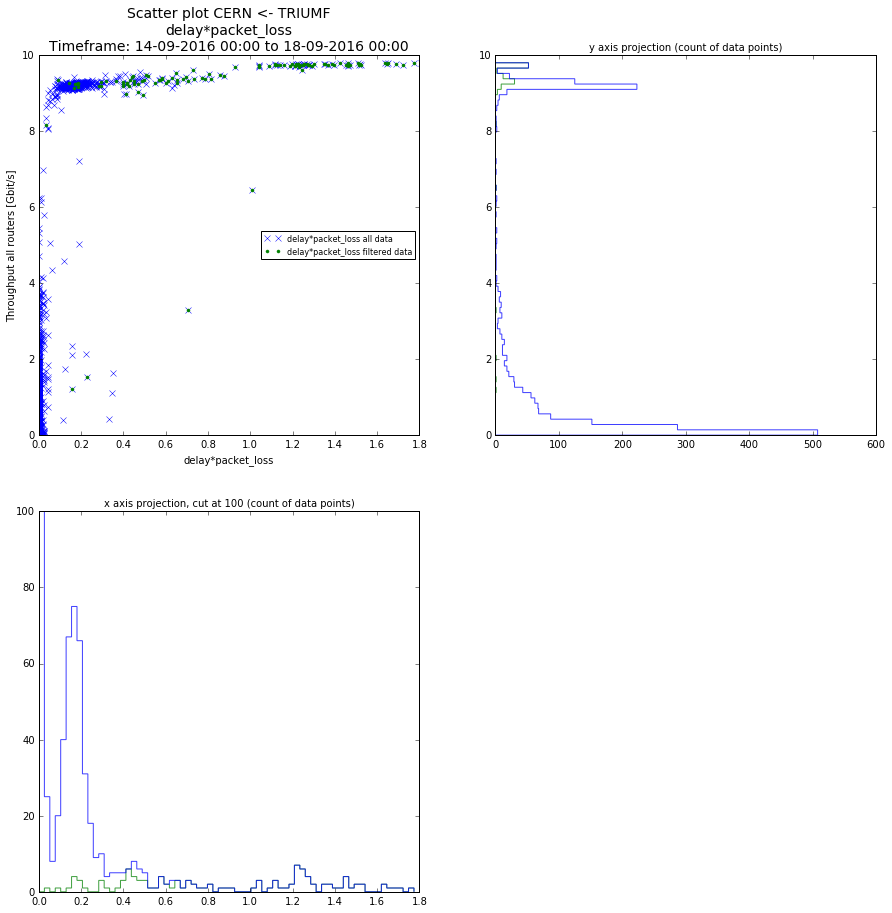

In [16]:
num_bins1 = 70
num_bins2 = 70
normed = False
xlim = (0, 1.8)

# plot the data we got
fig, ax1 = plt.subplots()
fig.set_size_inches(15,15)
fig.set_dpi(300)

plt.subplot(221)
# scaterplot itself
plt.title(title,fontsize=14)
plt.plot(data_set_noFilter['delay_avg']*data_set_noFilter['packet_loss'], data_set_noFilter['throughput']/1e9,
         'bx', label=further_info+" all data")
plt.plot(data_set['delay_avg']*data_set['packet_loss'], data_set['throughput']/1e9,
         'g.', label=further_info+" filtered data")
#plt.plot(data_set['delay_avg_gradient'], data_set['throughput']/1e9,
#         'b.', label=further_info)
#plt.plot((data_set['packet_loss']), data_set['throughput']/1e9,
#         'b.', label=further_info)
#plt.plot(data_set['packet_loss'], data_set['throughput']/1e9,
#         'b.', label=further_info)
#plt.plot(data_set['delay_avg'], data_set['throughput']/1e9,
#         'r.', label=further_info)
plt.ylabel("Throughput all routers [Gbit/s]")
plt.xlabel(further_info)

plt.legend(loc='best',fontsize=8)

ax1.set_ylim([-0.1, 0.1])
plt.xlim(xlim)
#plt.ylim((7,10))

# histogram y axis
plt.subplot(222)
plt.title("y axis projection (count of data points)",fontsize=10)
n, bins, patches = plt.hist([data_set_noFilter['throughput']/1e9, data_set['throughput']/1e9],
                            num_bins1, normed=normed, histtype='step', facecolor='green',
                                alpha=0.75, orientation='horizontal')

# histogram x axis
plt.subplot(223)
plt.title("x axis projection, cut at 100 (count of data points)",fontsize=10)
bin2 = np.arange(xlim[0], xlim[1], abs(xlim[0]-xlim[1])/num_bins2)
n, bins, patches = plt.hist([data_set_noFilter['delay_avg']*data_set_noFilter['packet_loss'],
                            data_set['delay_avg']*data_set['packet_loss']],
                            bin2, normed=normed, histtype='step', facecolor='green',
                                alpha=0.75, orientation='vertical')
plt.xlim(xlim)
plt.ylim(0, 100)


#plt.savefig('plots/a_presentation_plots/'+ fname +'_3.png', format='PNG', dpi=300)

plt.show()

## Multi plotting

In [17]:
def makePlot(src, dest, direction, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=''):
    # set stuff up
    direction_counter = "in"
    if direction == "in":
        direction_counter = "out"
    dirMarker = " <- "
    if direction == "out":
        dirMarker = " -> "
    title = "Multi plot for "+src+" "+dirMarker+" "+dest +"\nTimeframe: "+str(timeframe[0])+" to "+str(timeframe[1])
    fname = title
    # plot the data we got
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18,12)
    fig.set_dpi(300)
    plt.title(title,fontsize=14)

    # make first axis
    ax1.plot(dates_perfSonar[src][dest][direction], data_perfSonar[src][dest][direction]["delay_avg"]/10,
             'y', label=r'Delay /10')
    ax1.plot(dates_perfSonar[src][dest][direction_counter], data_perfSonar[src][dest][direction_counter]["delay_avg"]/10,
             'c', label=r'Reverse Direction: Delay /10')
    # get throughput
    throughputs = []
    for router in data_router.axes[1]:
        if dest in router and direction in router[len(router)-3:]:
            throughputs.append(data_router[router])
    combinded_throughput = sum(throughputs)
    ax1.plot(dates_router, combinded_throughput/1e9,
             'b', label=r'Throughput all ('+str(len(throughputs))+') routers')
    ax1.plot(dates_perfSonar[src][dest][direction], data_perfSonar[src][dest][direction]["throughput_perfSonar"]/1e9,
            'rx', label=r'Throughput perfSonar')
    # plot mathis
    
    
    # make second axis
    ax2 = ax1.twinx()
    ax2.plot(dates_perfSonar[src][dest][direction], data_perfSonar[src][dest][direction]["packet_loss"],
             'g', label=r'Packetloss')

    # limits
    #ax1.set_ylim([0, 20])
    ax2.set_ylim([0, 0.05])
    plt.xlim([dt.datetime.strptime(t, '%d-%m-%Y %H:%M') for t in timeframe])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
    plt.gcf().autofmt_xdate()
    # legends and lables
    ax1.set_ylabel("Throughput [Gbit/s] and Latency [ms/10]")
    ax1.set_xlabel("Time [s since epoch]")
    ax1.legend(loc='upper right',fontsize=14)
    ax2.set_ylabel("Packetloss")
    ax2.legend(loc='upper left',fontsize=14)
    ax1.grid(True, which='major')
    # saving?
    if savePath != '' :
        plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
    plt.show()

def makeAllPlots(timeframe, savePath = ''):
    for src in data_perfSonar.keys():
        for dest in data_perfSonar[src].keys():
            direction = "out"
            makePlot(src, dest, direction, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=savePath)
            direction = "in"
            makePlot(src, dest, direction, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=savePath)


In [18]:
#timeframe = ['11-09-2016 16:00', '02-10-2016 16:00']
timeframe = ['29-09-2016 16:00', '02-10-2016 16:00']
savePath = ''
#savePath = 'plots/router_multi_plots_2016-10-03_all-connections/'

#makeAllPlots(timeframe, savePath=savePath)

In [ ]:
# configuration
src = "CERN"
dest = "PIC"
direction = "in"
timeframe = ['10-09-2016 16:00', '02-10-2016 16:00']
savePath = ''
#savePath = 'plots/a_presentation_plots/'

makePlot(src, dest, direction, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=savePath)

In [17]:
def makePlot_custom(src_r, dest_r, direction_r, src_pS, dest_pS, direction_pS, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=''):
    # set stuff up
    direction_counter_r = "in"
    dirMarker_r = " <- "
    if direction_r == "out":
        dirMarker_r = " -> "
    direction_counter_pS = "in"
    if direction_pS == "in":
        direction_counter_pS = "out"
    dirMarker_pS = " <- "
    if direction_pS == "out":
        dirMarker_pS = " -> "
    title = "Most custom plot\nrouter: "+src_r+' '+dirMarker_r+' '+dest_r+'\nperfSonar: '+src_pS+' '+dirMarker_pS+' '+dest_pS+"\nTimeframe: "+str(timeframe[0])+" to "+str(timeframe[1])
    fname = title
    # plot the data we got
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18,12)
    fig.set_dpi(300)
    plt.title(title,fontsize=14)

    # make first axis
    ax1.plot(dates_perfSonar[src_pS][dest_pS][direction_pS], data_perfSonar[src_pS][dest_pS][direction_pS]["delay_avg"]/10,
             'y', label=src_pS+' '+dirMarker_pS+' '+dest_pS+': Delay /10')
    #ax1.plot(dates_perfSonar[src_pS][dest_pS][direction_counter_pS], data_perfSonar[src_pS][dest_pS][direction_counter_pS]["delay_avg"]/10,
    #         'c', label='Opposite:'+ src_pS+' '+dirMarker_pS+' '+dest_pS+': Delay /10')
    # get throughput
    throughputs = []
    for router in data_router.axes[1]:
        if dest_r in router and direction in router[len(router)-3:]:
            throughputs.append(data_router[router])
    combinded_throughput = sum(throughputs)
    ax1.plot(dates_router, combinded_throughput/1e9,
             'b', label=src_r+' '+dirMarker_r+' '+dest_r+': Throughput all ('+str(len(throughputs))+') routers')
    ax1.plot(dates_perfSonar[src_pS][dest_pS][direction_pS], data_perfSonar[src_pS][dest_pS][direction_pS]["throughput_perfSonar"]/1e9,
            'rx', label=src_pS+' '+dirMarker_pS+' '+dest_pS+': Throughput perfSonar')
    # plot mathis
    
    
    # make second axis
    ax2 = ax1.twinx()
    ax2.plot(dates_perfSonar[src_pS][dest_pS][direction_pS], data_perfSonar[src_pS][dest_pS][direction_pS]["packet_loss"],
             'g', label=src_pS+' '+dirMarker_pS+' '+dest_pS+': Packetloss')

    # limits
    #ax1.set_ylim([0, 20])
    ax2.set_ylim([0, 0.05])
    plt.xlim([dt.datetime.strptime(t, '%d-%m-%Y %H:%M') for t in timeframe])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
    plt.gcf().autofmt_xdate()
    # legends and lables
    ax1.set_ylabel("Throughput [Gbit/s] and Latency [ms/10]")
    ax1.set_xlabel("Time [date]")
    ax1.legend(loc='upper left',fontsize=14)
    ax2.set_ylabel("Packetloss")
    ax2.legend(loc='upper right',fontsize=14)
    # saving?
    if savePath != '' :
        plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
    plt.show()

KeyError: 'PIC'

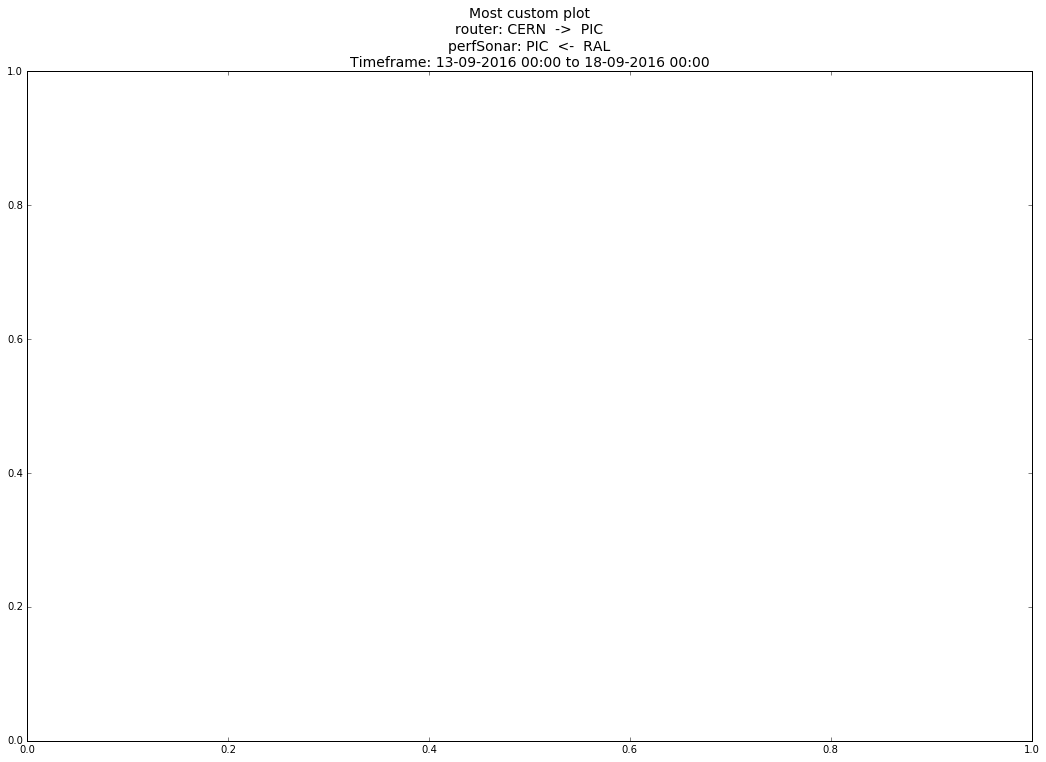

In [18]:
# custom plot
src_r = "CERN"
dest_r = "PIC"
direction_r = "out"
src_pS = "PIC"
dest_pS = "RAL"
direction_pS = "in"
timeframe = ['13-09-2016 00:00', '18-09-2016 00:00']
savePath = ''
#savePath = 'plots/router_multi_plots_2016-09-22/'

makePlot_custom(src_r, dest_r, direction_r, src_pS, dest_pS, direction_pS, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=savePath)

## Histogram plotting

In [19]:
def makeHist1(src, dest, pdCol, num_bins, title_begin, savePath=''):
    dataList = [data_perfSonar[src][dest]['out'][pdCol].as_matrix(), data_perfSonar[src][dest]['in'][pdCol].as_matrix()]
    normed = True
    fig, ax1 = plt.subplots()
    fig.set_size_inches(9,10)
    fig.set_dpi(300)

    plt.subplot(211)
    n, bins, patches = plt.hist(dataList[0], num_bins, normed=normed, histtype='step', facecolor='green',
                                alpha=0.75, orientation='vertical')

    plt.xlabel(pdCol)
    plt.ylabel('Probability [1]')
    title1 = title_begin + "\n"+src+" -> "+dest
    plt.title(title1, fontsize=14)
    plt.grid(True)
    x_lim1 = plt.gca().get_xlim()

    plt.subplot(212)
    n, bins, patches = plt.hist(dataList[1], num_bins, normed=normed, histtype='step', facecolor='green',
                                alpha=0.75, orientation='vertical')

    plt.xlabel(pdCol)
    plt.ylabel('Probability [1]')
    title2 = src+" <- "+dest
    plt.title(title2, fontsize=14)
    plt.grid(True)
    x_lim2 = plt.gca().get_xlim()

    lim2set = [0,0]

    if x_lim1[0] > x_lim2[0]:
        lim2set[0] = x_lim2[0]
    else:
        lim2set[0] = x_lim1[0]

    if x_lim1[1] < x_lim2[1]:
        lim2set[1] = x_lim2[1]
    else:
        lim2set[1] = x_lim1[1]

    lim2set = [0,0.01]
    plt.subplot(211)
    plt.gca().set_xlim(lim2set)
    plt.subplot(212)
    plt.gca().set_xlim(lim2set)

    if savePath != '' :
        fname = title1
        plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
    plt.show()
    
def makeHist2(src, dest, pdCol, num_bins, title_begin, savePath=''):
    dataList = [data_perfSonar[src][dest]['out'][pdCol].as_matrix(), data_perfSonar[src][dest]['in'][pdCol].as_matrix()]
    normed = False
    print(dataList)
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12,7)
    fig.set_dpi(300)
    #n, bins, patches = plt.hist(dataList, bins=num_bins, normed=normed, histtype='step', facecolor='green',
    #                            alpha=0.75, orientation='vertical')
    n, bins, patches = plt.hist(dataList, histtype='step', bins=200, stacked=True)
    plt.yscale('log', nonposy='clip')
    
    plt.xlabel(pdCol)
    plt.ylabel('Count [1]')
    title1 = title_begin + "\n"+src+" <-> "+dest + "\nbins are stacked, blue: in, green: out"
    plt.title(title1, fontsize=14)
    plt.grid(True)

    if savePath != '' :
        fname = title1
        plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
    plt.show()
    

[array([ 76.4536    ,  76.45407778,  76.45447778, ...,  76.29052222,
        76.29668889,  76.30004444]), array([  77.00305556,   77.00526667,   77.02231111, ...,  111.2974    ,
        107.18625556,  105.59441111])]


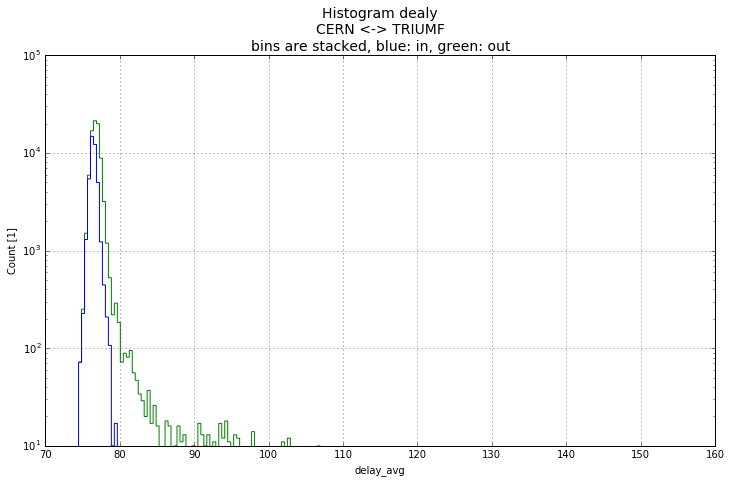

In [20]:
# configuration
src = "CERN"
dest = "TRIUMF"
direction = "out"
pdCol = 'delay_avg'
num_bins = 200
num_bins = np.arange(0, 0.003, 0.00005)
title_begin = "Histogram dealy"
savePath = ''
#savePath = 'plots/a_presentation_plots/'

#for dest in data_perfSonar[src]:
makeHist2(src, dest, pdCol, num_bins, title_begin, savePath=savePath)


## Do NN learning

In [21]:
def findIndexClosestToTimestamp_mod(timestamp, dataPoints, collumThatIsNotNAN):
    '''
    Returns a data point from dataPoints, that is closest to the given timestamp.
    As well the dataPoint will not be nan in the collum "collumThatIsNotNAN"
    Complexity of this command: O( log( len(dataPoints) ) )
    '''
    timestamps_toSearch = dataPoints.axes[0]
    cols = list(dataPoints.axes[1])
    data = dataPoints.values
    # bisect only works because we know our list is sorted
    pos = bisect_left(timestamps_toSearch, timestamp)
    if pos == len(dataPoints):
        pos = len(dataPoints)-1
    #print(pos)
    # find the closest datapoint, that is not a NAN and return it
    currentDataPoint = dict(zip(cols, dataPoints.values[pos]))
    if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
        return pos
    else:
        pos = findIndexClostestThatIsNotNAN(pos, dataPoints, cols.index(collumThatIsNotNAN))
        return pos

# TODO: add the minimum
def makeNewDataSet_NN(data_from_routers, data_from_perfSonar, timeframe, num_of_last_measurements=10, cut_throughput=0.7, throughput_max=(20*1e9)):
    # bisect doesn't work if the data is not sortet this way...
    data_from_routers = data_from_routers.sort_index(ascending=True).copy(deep=True)
    data_from_perfSonar = data_from_perfSonar.sort_index(ascending=True).copy(deep=True)
    # cut routers data
    pos1 = bisect_left(data_from_routers.index, timeframe[0])
    if pos1 == len(data_from_routers):
        pos1 = len(data_from_routers)-1
    pos2 = bisect_left(data_from_routers.index, timeframe[1])
    if pos2 == len(data_from_routers):
        pos2 = len(data_from_routers)-1
    data_from_routers = data_from_routers.drop(data_from_routers.index[0:pos1])
    data_from_routers = data_from_routers.drop(data_from_routers.index[pos2:len(data_from_routers)-1])
    data = []
    delay_all_time_avg = data_from_perfSonar['delay_avg'].mean()
    delay_all_time_std = data_from_perfSonar['delay_avg'].std()
    delay_all_time_min = data_from_perfSonar['delay_avg'].min()
    loss_all_time_avg = data_from_perfSonar['packet_loss'].mean()
    loss_all_time_std = data_from_perfSonar['packet_loss'].std()
    for i in range(len(data_from_routers)):
        if math.isnan(data_from_routers.values[i]) or data_from_routers.values[i] == 0.0:
            continue
        currentTimestamp = data_from_routers.index[i]
        index_perfSonar = findIndexClosestToTimestamp_mod(currentTimestamp, data_from_perfSonar, 'delay_avg')
        zw = dict(data_from_perfSonar.iloc[index_perfSonar])
        # include all time data
        zw['delay_all_time_avg'] = delay_all_time_avg
        zw['delay_all_time_std'] = delay_all_time_std
        zw['delay_all_time_min'] = delay_all_time_min
        zw['loss_all_time_avg'] = loss_all_time_avg
        zw['loss_all_time_std'] = loss_all_time_std
        # add last measurements
        if index_perfSonar < num_of_last_measurements:
            continue
        sumdelay = 0
        sumdelay_square = 0
        sumloss = 0
        sumloss_square = 0
        for j in range(1, num_of_last_measurements+1):
            dataPoint = data_from_perfSonar.iloc[index_perfSonar-j]
            zw['delay_avg_past_'+str(j)] = dataPoint['delay_avg']
            sumdelay += dataPoint['delay_avg']
            sumdelay_square += dataPoint['delay_avg']*dataPoint['delay_avg']
            zw['packet_loss_past_'+str(j)] = dataPoint['packet_loss']
            sumloss += dataPoint['packet_loss']
            sumloss_square += dataPoint['packet_loss']*dataPoint['packet_loss']
        zw['delay_avg_past_avg'] = sumdelay/num_of_last_measurements
        zw['packet_loss_past_avg'] = sumloss/num_of_last_measurements
        zw['delay_avg_past_std'] = np.sqrt((sumdelay_square/num_of_last_measurements)-(sumdelay/num_of_last_measurements)**2)
        zw['packet_loss_past_std'] = np.sqrt((sumloss_square/num_of_last_measurements)-(sumloss/num_of_last_measurements)**2)
        if math.isnan(zw['packet_loss_past_std']):
            zw['packet_loss_past_std'] = 0
        if math.isnan(zw['delay_avg_past_std']):
            zw['delay_avg_past_std'] = 0
        # add timestamp and throughput
        zw['timestamp'] = currentTimestamp
        zw['throughput'] = data_from_routers.values[i]
        if zw['throughput'] <= cut_throughput*throughput_max:
            zw['throughput'] = 0
        # pop deprecated data
        zw.pop('ttl_median', None)
        zw.pop('ttl_avg', None)
        zw.pop('ttl_std', None)
        zw.pop('time_error_estimates', None)
        data.append(zw)
    data = pd.DataFrame.from_dict(data)
    return data

def normalizeDataSet(dataSet, scaler_feature_range=(0, 1), scaler=None):
    # make sure we don't change our original object (wo don't want that)
    # use the sktlearn.preprocessing procedures, they prommis to be quite flexible
    workDataSet = dataSet.copy(deep=True)
    # append zeroes so that we are actually normalized to zero
    #zeroesDataFrame = pd.DataFrame(np.zeros([1,len(workDataSet.axes[1])]), columns=workDataSet.axes[1])
    #workDataSet = workDataSet.append(zeroesDataFrame, ignore_index=True)
    # fill up our nans as the function dosen't run with nans 
    workDataSet = workDataSet.fillna(0)
    collums = []
    for collum in workDataSet.axes[1]:
        # what to skip:
        if collum == "timestamp" or collum == "throughput" or collum == "throughput_perfSonar":
            continue
        collums.append(collum)
    # if you want to keep the scaler, then split this into a fit and a transform call
    if scaler == None:
        scaler = preprocessing.MinMaxScaler(feature_range=scaler_feature_range).fit(workDataSet[collums].as_matrix())
    workDataSet[collums] = scaler.transform(workDataSet[collums].as_matrix())
    # remove zeroes again
    #workDataSet = workDataSet.drop(len(workDataSet)-1, axis=0)
    return workDataSet, scaler

def inverseNormalizeDataSet(dataSet, scaler):
    # make sure we don't change our original object (wo don't want that)
    # use the sktlearn.preprocessing procedures, they prommis to be quite flexible
    workDataSet = dataSet.copy(deep=True)
    collums = []
    for collum in workDataSet.axes[1]:
        # what to skip:
        if collum == "timestamp" or collum == "throughput":
            continue
        collums.append(collum)
    workDataSet[collums] = scaler.inverse_transform(workDataSet[collums].as_matrix())
    # remove zeroes again
    #workDataSet = workDataSet.drop(len(workDataSet)-1, axis=0)
    return workDataSet

def normalize_throughput(throughput_array, throughputMaxGBits):
    zw = throughput_array
    zw = throughput_array/(throughputMaxGBits*1e9)
    zw = (zw*0.8)+0.1
    return zw

def inverses_normalize_throughput(throughput_array, throughputMaxGBits):
    zw = throughput_array
    zw = (zw-0.1)/0.8
    zw = zw * (throughputMaxGBits*1e9)
    return zw

def make_all_data_sets_for_NN(timeframe_ext, num_of_last_measurements, cut_throughput, throughput_mapping):
    # set up stuff
    timeframe = [calendar.timegm(dt.datetime.strptime(t, '%d-%m-%Y %H:%M').timetuple()) for t in timeframe_ext]
    # get all directions
    data_set = pd.DataFrame()
    for src in data_perfSonar.keys():
        for dest in data_perfSonar[src].keys():
            # skip JINR-T1 it has super strange router data...
            # as well skip RAL, they have a baaaad router
            if dest == "JINR-T1" or dest == "RAL":
                continue
            #if dest == "JINR-T1":
            #    continue
            throughputMaxGBits = throughput_mapping[dest]
            # make dataset for direction: in
            direction = "out"
            print("Creating data_set: "+src+" and "+dest+" dir: "+direction)
            throughputs = []
            for router in data_router.axes[1]:
                if dest in router and direction in router[len(router)-3:]:
                    throughputs.append(data_router[router])
            data_from_routers = sum(throughputs).copy(deep=True)
            data_from_perfSonar = data_perfSonar[src][dest][direction].copy(deep=True)
            data_set_tmp = makeNewDataSet_NN(data_from_routers, data_from_perfSonar,
                                             timeframe, num_of_last_measurements=num_of_last_measurements,
                                             cut_throughput=cut_throughput, throughput_max=(throughputMaxGBits*1e9))
            # normalize throughput
            data_set_tmp['throughput'] = normalize_throughput(data_set_tmp['throughput'], throughputMaxGBits)
            # append data_set
            data_set = data_set.append(data_set_tmp, ignore_index=True)
            # make dataset for direction: out
            # basically do the same
            direction = "in"
            print("Creating data_set: "+src+" and "+dest+" dir: "+direction)
            throughputs = []
            for router in data_router.axes[1]:
                if dest in router and direction in router[len(router)-3:]:
                    throughputs.append(data_router[router])
            data_from_routers = sum(throughputs).copy(deep=True)
            data_from_perfSonar = data_perfSonar[src][dest][direction].copy(deep=True)
            data_set_tmp = makeNewDataSet_NN(data_from_routers, data_from_perfSonar,
                                             timeframe, num_of_last_measurements=num_of_last_measurements,
                                             cut_throughput=cut_throughput, throughput_max=(throughputMaxGBits*1e9))
            data_set_tmp['throughput'] = normalize_throughput(data_set_tmp['throughput'], throughputMaxGBits)
            data_set = data_set.append(data_set_tmp, ignore_index=True)
    return data_set


def convert_normal_data_set_to_classification(data_set_orig, cut_throughput):
    out_data_set = data_set_orig.copy(deep=True)
    for i in out_data_set.index:
        if (out_data_set['throughput'][i]-0.1)/0.8 >= cut_throughput:
            out_data_set['throughput'][i] = 0.9
    return out_data_set


In [22]:
data_set_all['throughput'][1]

NameError: name 'data_set_all' is not defined

### Train NN

In [23]:
throughput_mapping = {"JINR-T1": 20, "RAL": 20, "TRIUMF": 10, "CNAF": 40, "KIT": 20,
                      "CCIN2P3": 20, "PIC": 10, "BNL": 50}
num_of_last_measurements = 15
cut_throughput = 0.7
timeframe_readable_train = ['11-09-2016 16:00', '28-09-2016 16:00']

data_set_all = make_all_data_sets_for_NN(timeframe_readable_train, num_of_last_measurements, cut_throughput, throughput_mapping)

Creating data_set: CERN and TRIUMF dir: out
Creating data_set: CERN and TRIUMF dir: in
Creating data_set: CERN and PIC dir: out
Creating data_set: CERN and PIC dir: in
Creating data_set: CERN and KIT dir: out
Creating data_set: CERN and KIT dir: in
Creating data_set: CERN and CCIN2P3 dir: out
Creating data_set: CERN and CCIN2P3 dir: in
Creating data_set: CERN and CNAF dir: out
Creating data_set: CERN and CNAF dir: in
Creating data_set: CERN and BNL dir: out
Creating data_set: CERN and BNL dir: in


In [24]:
%%capture
# we don't want to see the output, as it badly slows the browser

data_set_normalized, scaler_for_dataSet_all = normalizeDataSet(data_set_all)

# do classification conversion
data_set_normalized = convert_normal_data_set_to_classification(data_set_normalized, cut_throughput)

data_set_normalized_NN_Input = data_set_normalized.drop(['throughput','timestamp','throughput_perfSonar'], axis=1)
data_set_normalized_NN_Output = data_set_normalized['throughput']



from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

activation_func = 'relu'
init_func = 'uniform'
layer_init = ""
# standard:
#b_size = 32
b_size = 128
validation_split = 0.0
training_epochs = 75
dropout_ratio = 0.5

model = Sequential()
model.add(Dense(100, input_dim=len(data_set_normalized_NN_Input.axes[1]), activation=activation_func, init=init_func))
model.add(Dropout(dropout_ratio))
model.add(Dense(50, activation=activation_func, init=init_func))
model.add(Dropout(dropout_ratio))
model.add(Dense(5, activation=activation_func, init=init_func))
# last/output layer
model.add(Dense(1, activation=activation_func))

model.compile(optimizer='rmsprop', loss='mse')
hist = model.fit(data_set_normalized_NN_Input.as_matrix(), data_set_normalized_NN_Output.as_matrix(),
                    nb_epoch=training_epochs, batch_size=b_size, shuffle=True, validation_split=validation_split)

KeyError: 'acc'

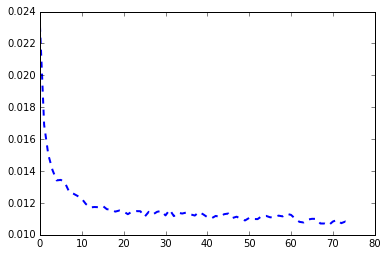

In [25]:
x = np.linspace(0,training_epochs-1,training_epochs)
plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
plt.legend()
plt.show()

In [57]:
import pickle
# save model
model.save('global_NN_for_netTel.h5')  # creates a HDF5 file 'global_NN_model_1.h5'
# save our scaler
pickle.dump(scaler_for_dataSet_all, open( "global_NN_for_netTel_scaler.pkl", "wb" ),
            protocol=2 )

### Validate on other timeframe

In [93]:
throughput_mapping = {"JINR-T1": 20, "RAL": 20, "TRIUMF": 10, "CNAF": 40, "KIT": 20,
                      "CCIN2P3": 20, "PIC": 10, "BNL": 50}
num_of_last_measurements = 15
cut_throughput = 0.7
timeframe_readable = ['28-09-2016 16:00', '02-10-2016 16:00']

data_set2 = make_all_data_sets_for_NN(timeframe_readable, num_of_last_measurements, cut_throughput, throughput_mapping)

Creating data_set: CERN and CCIN2P3 dir: out
Creating data_set: CERN and CCIN2P3 dir: in
Creating data_set: CERN and CNAF dir: out
Creating data_set: CERN and CNAF dir: in
Creating data_set: CERN and BNL dir: out
Creating data_set: CERN and BNL dir: in
Creating data_set: CERN and KIT dir: out
Creating data_set: CERN and KIT dir: in
Creating data_set: CERN and TRIUMF dir: out
Creating data_set: CERN and TRIUMF dir: in
Creating data_set: CERN and PIC dir: out
Creating data_set: CERN and PIC dir: in


13952/14664 [===========================>..] - ETA: 0s

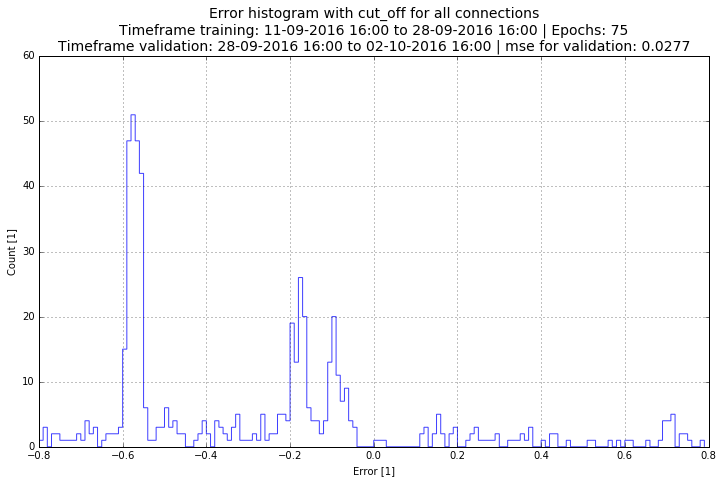

In [103]:
data_set_normalized, useless_scaler = normalizeDataSet(data_set2, scaler=scaler_for_dataSet_all)
# do classification conversion
data_set_normalized = convert_normal_data_set_to_classification(data_set_normalized, cut_throughput)
data_set_normalized_NN_Input = data_set_normalized.drop(['throughput','timestamp','throughput_perfSonar'], axis=1)
data_set_normalized_NN_Output = data_set_normalized['throughput']

score = model.evaluate(data_set_normalized_NN_Input.as_matrix(), data_set_normalized_NN_Output.as_matrix(),
                       batch_size=b_size)
prediction = model.predict(data_set_normalized_NN_Input.as_matrix(), batch_size=b_size)

# make error histogram
bins = np.arange(-0.8, 0.8, 0.01)
#bins = 300
cut_offset = 0.1
#cut_offset = 0.06
savePath = ''
#savePath = 'plots/a_presentation_plots/'

title = "Error histogram with cut_off for all connections"
title += "\nTimeframe training: "+str(timeframe_readable_train[0])+" to "+str(timeframe_readable_train[1]) + " | Epochs: "+ str(training_epochs) 
#title += "\n activation func: " + activation_func
title += "\nTimeframe validation: "+str(timeframe_readable[0])+" to "+str(timeframe_readable[1])
title += " | "+ str(model.loss) +" for validation: " + str(round(score, 4))

rs_prediction = np.reshape(prediction, (len(prediction),))
actual = data_set_normalized_NN_Output.as_matrix()
diff = rs_prediction - actual
diff = diff
# cut median, its falsely called minimum here
minimum = np.median(rs_prediction)
validPoints = []
for i in range(len(diff)):
    if rs_prediction[i] >= (minimum+cut_offset):
        validPoints.append(diff[i])
    elif actual[i] >= (minimum+cut_offset):
        validPoints.append(diff[i])
fig, ax1 = plt.subplots()
fig.set_size_inches(12,7)
fig.set_dpi(300)
n, bins, patches = plt.hist(validPoints, bins, normed=False, histtype='step', facecolor='green',
                            alpha=0.75, orientation='vertical')

plt.xlabel("Error [1]")
plt.ylabel('Count [1]')
plt.title(title, fontsize=14)
plt.grid(True)

if savePath != '' :
    fname = title
    plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

### Validate on one specific connection

In [104]:
# create data Set
# configuration
src = "CERN"
dest = "RAL"
direction = "out"
num_of_last_measurements = 15
throughputMaxGBits = 20
throughputPercentage = 0.7
timeframe_readable = ['11-09-2016 16:00', '27-09-2016 16:00']
#timeframe_readable = ['27-09-2016 16:00', '02-10-2016 16:00']
#scaler = None
scaler = scaler_for_dataSet_all

# setting stuff up
timeframe = [calendar.timegm(dt.datetime.strptime(t, '%d-%m-%Y %H:%M').timetuple()) for t in timeframe_readable]

# make dataSet
print("Creating data_set: "+src+" and "+dest+" | dir: "+direction)
throughputs = []
for router in data_router.axes[1]:
    if dest in router and direction in router[len(router)-3:]:
        throughputs.append(data_router[router])
data_from_routers = sum(throughputs).copy(deep=True)
data_from_perfSonar = data_perfSonar[src][dest][direction].copy(deep=True)

data_set1 = makeNewDataSet_NN(data_from_routers, data_from_perfSonar,
                             timeframe, num_of_last_measurements=num_of_last_measurements,
                            cut_throughput=cut_throughput, throughput_max=(throughputMaxGBits*1e9))

print("data_set size: "+ str(len(data_set1)))
print("vars per data point: "+ str(len(data_set1.axes[1])))

Creating data_set: CERN and RAL | dir: out
data_set size: 4753
vars per data point: 48


4736/4753 [============================>.] - ETA: 0s

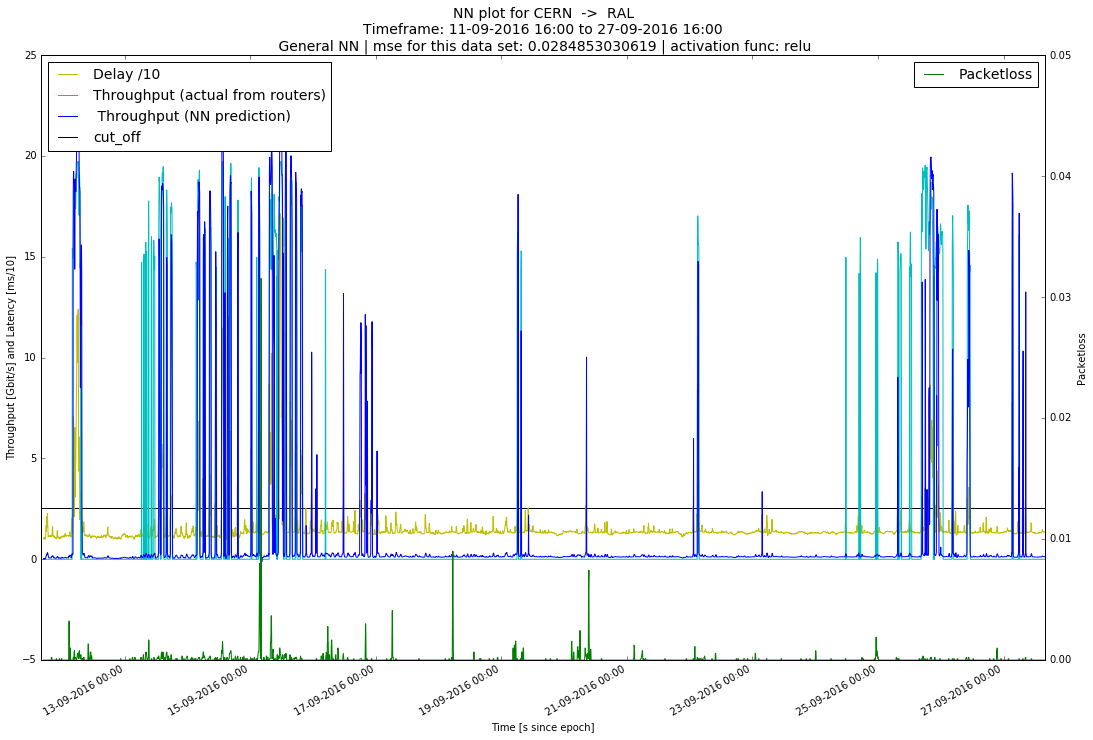

In [105]:
data_set_normalized, useless_slacer_2 = normalizeDataSet(data_set1, scaler=scaler)
# do classification conversion
data_set_normalized = convert_normal_data_set_to_classification(data_set_normalized, cut_throughput)
data_set_normalized['throughput'] = normalize_throughput(data_set_normalized['throughput'], throughputMaxGBits)

data_set_normalized_NN_Input = data_set_normalized.drop(['throughput','timestamp','throughput_perfSonar'], axis=1)
data_set_normalized_NN_Output = data_set_normalized['throughput']

score = model.evaluate(data_set_normalized_NN_Input.as_matrix(), data_set_normalized_NN_Output.as_matrix(),
                       batch_size=b_size)
prediction = model.predict(data_set_normalized_NN_Input.as_matrix(), batch_size=b_size)

timeframe_readable_new = timeframe_readable
#timeframe_readable_new = ['14-09-2016 06:00', '16-09-2016 00:00']
savePath = ''
#savePath = 'plots/router_multi_plots_2016-09-29/'
title_suffix = "\n General NN | "+ str(model.loss) +" for this data set: " + str(score) + " | activation func: " + activation_func

title_NN_plot = makePlot_forNN(src, dest, direction, timeframe_readable_new,
               data_set1, inverses_normalize_throughput(prediction, throughputMaxGBits), title_suffix=title_suffix, savePath=savePath)

median is: 0.110369


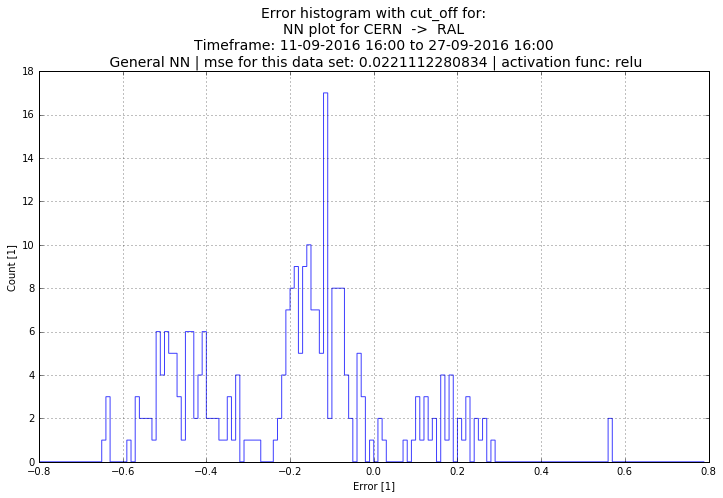

In [41]:
# make error histogram
bins = np.arange(-0.8, 0.8, 0.01)
cut_offset = 0.06
savePath = ''
#savePath = 'plots/router_multi_plots_2016-09-29/'
title = "Error histogram with cut_off for:\n" + title_NN_plot

rs_prediction = np.reshape(prediction, (len(prediction),))
diff = rs_prediction - data_set_normalized_NN_Output.as_matrix()
diff = diff
# cut minimum
minimum = np.median(rs_prediction)
print("median is: "+str(minimum))
validPoints = []
for i in range(len(diff)):
    if rs_prediction[i] >= (minimum+cut_offset):
        validPoints.append(diff[i])
fig, ax1 = plt.subplots()
fig.set_size_inches(12,7)
fig.set_dpi(300)
n, bins, patches = plt.hist(validPoints, bins, normed=False, histtype='step', facecolor='green',
                            alpha=0.75, orientation='vertical')

plt.xlabel("Error [1]")
plt.ylabel('Count [1]')
plt.title(title, fontsize=14)
plt.grid(True)

if savePath != '' :
    fname = title
    plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


13824/14664 [===========================>..] - ETA: 0s

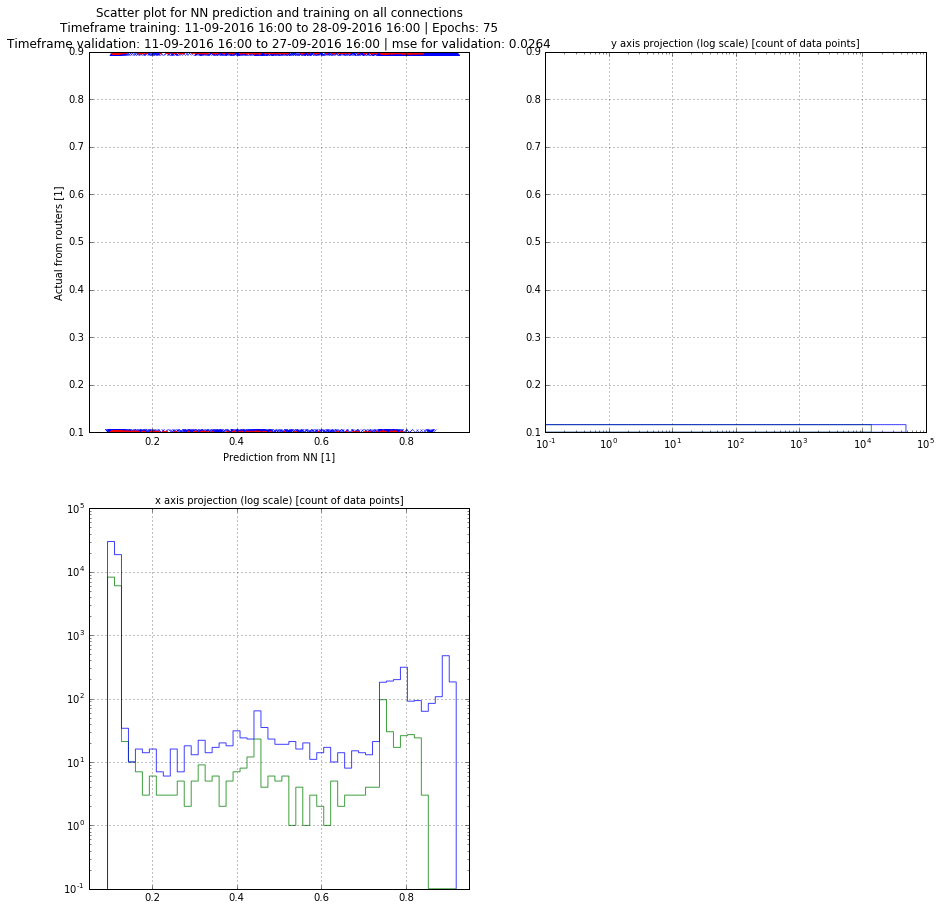

In [113]:
# scatter plot, yeah!

# create data fro training and validation sets

data_set_normalized, useless_scaler = normalizeDataSet(data_set2, scaler=scaler_for_dataSet_all)
# do classification conversion
data_set_normalized = convert_normal_data_set_to_classification(data_set_normalized, cut_throughput)
data_set_normalized_NN_Input = data_set_normalized.drop(['throughput','timestamp','throughput_perfSonar'], axis=1)
data_set_normalized_NN_Output = data_set_normalized['throughput']

score = model.evaluate(data_set_normalized_NN_Input.as_matrix(), data_set_normalized_NN_Output.as_matrix(),
                       batch_size=b_size)

validation_prediction = model.predict(data_set_normalized_NN_Input.as_matrix(), batch_size=b_size)
# do reshaping
validation_prediction = np.reshape(validation_prediction, (len(validation_prediction),))
validation_actual = data_set_normalized_NN_Output.as_matrix()

data_set_normalized, scaler_for_dataSet_all = normalizeDataSet(data_set_all)
# do classification conversion
data_set_normalized = convert_normal_data_set_to_classification(data_set_normalized, cut_throughput)
data_set_normalized_NN_Input = data_set_normalized.drop(['throughput','timestamp','throughput_perfSonar'], axis=1)
data_set_normalized_NN_Output = data_set_normalized['throughput']
training_prediction = model.predict(data_set_normalized_NN_Input.as_matrix(), batch_size=b_size)
training_prediction = np.reshape(training_prediction, (len(training_prediction),))
training_actual = data_set_normalized_NN_Output.as_matrix()


savePath = ''
#savePath = 'plots/a_presentation_plots/'

num_bins1 = 50
num_bins2 = 50
normed = False
ylim = (0.1, 0.9)
xlim = (0.05, 0.95)

title = "Scatter plot for NN prediction and training on all connections"
title += "\nTimeframe training: "+str(timeframe_readable_train[0])+" to "+str(timeframe_readable_train[1]) + " | Epochs: "+ str(training_epochs) 
title += "\nTimeframe validation: "+str(timeframe_readable[0])+" to "+str(timeframe_readable[1])
title += " | "+ str(model.loss) +" for validation: " + str(round(score, 4))


validation_pointsForXprojection = []
for i in range(len(validation_actual)):
    if validation_actual[i] >= ylim[0]:
        validation_pointsForXprojection.append(validation_prediction[i])
        
training_pointsForXprojection = []
for i in range(len(training_actual)):
    if training_actual[i] >= ylim[0]:
        training_pointsForXprojection.append(training_prediction[i])


# plot the data we got
fig, ax1 = plt.subplots()
fig.set_size_inches(15,15)
fig.set_dpi(300)

plt.subplot(221)
# scaterplot itself
plt.title(title,fontsize=12)
plt.plot(training_prediction, training_actual, 'bx', label="")
plt.plot(validation_prediction, validation_actual, 'r.', label="")
plt.ylabel("Actual from routers [1]")
plt.xlabel("Prediction from NN [1]")
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(True)

# histogram y axis
plt.subplot(222)
bin1 = np.arange(ylim[0], ylim[1], abs(ylim[0]-ylim[1])/num_bins1)
plt.title("y axis projection (log scale) [count of data points]",fontsize=10)
n, bins, patches = plt.hist([training_actual, validation_actual], bin1,
                            normed=normed, histtype='step', facecolor='red',
                            alpha=0.75, orientation='horizontal', log=True)
plt.grid(True)

# histogram x axis
plt.subplot(223)
plt.title("x axis projection (log scale) [count of data points]",fontsize=10)
bin2 = np.arange(xlim[0], xlim[1], abs(xlim[0]-xlim[1])/num_bins2)
n, bins, patches = plt.hist([training_pointsForXprojection, validation_pointsForXprojection], num_bins2,
                            normed=normed, histtype='step', facecolor='red',
                            alpha=0.75, orientation='vertical', log=True)
plt.xlim(xlim)
#plt.ylim(0, 100)
plt.grid(True)

if savePath != '' :
    fname = title
    plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

In [39]:
def makePlot_forNN(src, dest, direction, timeframe, data_set_local, prediction_bw, title_suffix='', savePath=''):
    # set stuff up
    direction_counter = "in"
    if direction == "in":
        direction_counter = "out"
    dirMarker = " <- "
    if direction == "out":
        dirMarker = " -> "
    title = "NN plot for "+src+" "+dirMarker+" "+dest +"\nTimeframe: "+str(timeframe[0])+" to "+str(timeframe[1])+title_suffix
    fname = title
    # make dates
    dates_data_set = []
    for stamp in data_set_local['timestamp']:
        dates_data_set.append(dt.datetime.fromtimestamp(stamp))
    # plot the data we got
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18,12)
    fig.set_dpi(300)
    plt.title(title,fontsize=14)

    # make first axis
    ax1.hlines(inverses_normalize_throughput((minimum+cut_offset), throughputMaxGBits)/1e9, [0], [999999999999999999], label="cut_off")
    ax1.plot(dates_data_set, data_set_local["delay_avg"]/10,
             'y', label=r'Delay /10')
    # get throughput
    ax1.plot(dates_data_set, data_set_local['throughput']/1e9,
             'c', label=r'Throughput (actual from routers)')
    ax1.plot(dates_data_set, prediction_bw/1e9,
             'b', label=r' Throughput (NN prediction)')
    
    # make second axis
    ax2 = ax1.twinx()
    ax2.plot(dates_data_set, data_set_local["packet_loss"],
             'g', label=r'Packetloss')

    # limits
    #ax1.set_ylim([0, 20])
    ax2.set_ylim([0, 0.05])
    plt.xlim([dt.datetime.strptime(t, '%d-%m-%Y %H:%M') for t in timeframe])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
    plt.gcf().autofmt_xdate()
    # legends and lables
    ax1.set_ylabel("Throughput [Gbit/s] and Latency [ms/10]")
    ax1.set_xlabel("Time [s since epoch]")
    ax1.legend(loc='upper left',fontsize=14)
    ax2.set_ylabel("Packetloss")
    ax2.legend(loc='upper right',fontsize=14)
    # saving?
    if savePath != '' :
        plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
    plt.show()
    return title

In [1573]:
len(data_set_normalized_NN_Input.axes[1])

45

In [690]:
print(score)

0.0196422660113
